# PUP Part 1: dataset building, preprocessing data, and training some intro models

PUP = processing URL pipeline

## Part 1 of this notebook series takes in the massive conglom dataset constructed from various known ad, tracking, phishing, and malware domain lists.

## Then, as described in: `Lin, M.-S., et al.: Malicious URL filtering- a big data application. IEEE International Conference on Big Data (2013)` we are going to extract features from URLs for use in training decision trees and possible random forests.

* Please note that while I am citing the work above, and I used many of their features, their code was not available online. So this is my own implementation. I have also added features that were not existent in the `Lin 2013` paper.

## Finally, we train a decision tree and look at feature importance briefly, just to get a sense for what is going on here. This pipeline is the result of a lot of work and tweaking, not all of which is shown in line.

### Updated, for Part 4 of this notebook (training a GPT model from scratch) see `4-pup-gpt2.ipynb`

### To set up the conda environment, run the following command:
`conda create --name mut-environment jupyterlab numpy pandas matplotlib torch scikit-learn transformers joblib`

In [6]:
import joblib
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from torch.utils.data import DataLoader, Dataset
from transformers import DataCollatorWithPadding, GPT2ForSequenceClassification, GPT2Tokenizer, Trainer, TrainingArguments
from urllib.parse import urlparse

Step 1: Lexical features extraction: split URLs into components, apply a sliding window to the domain, and use a bag-of-words model to describe each component.

In [7]:
def lexicalFE(url): #lexical feature extraction fn - takes in a URL
    if not urlparse(url).scheme:
        url = 'http://' + url  # prepend with default scheme
    
    try:
        parsedURL = urlparse(url)
        domain = parsedURL.netloc
        path = parsedURL.path
        query = parsedURL.query
        domainNoPrefix = domain.replace('www.', '')
        features = {
            'domain': domain,
            'domainNoPrefix': domainNoPrefix,
            'domainLength': len(domain),
            'pathLength': len(path),
            'queryLength': len(query),
            'numPathComponents': len(path.split('/')) - 1,  # sub 1 b/c leading '/' results in an empty string at the start
            'numQueryComponents': len(query.split('&')) if query else 0,  # only count if there's a query
            'hasDigitsInDomain': any(char.isdigit() for char in domain),
            'hasDigitsInPath': any(char.isdigit() for char in path),
            'hasDigitsInQuery': any(char.isdigit() for char in query)
        }
        return features
    except ValueError as e: #handle errors TODO: more here
        print(f"Error processing URL {url}: {e}")
        return {}

Step 2: descriptive features extraction - this function will further split the path component, remove common prefixes and TLDs, and calc stats

In [8]:
def descriptiveFE(url): # desc. feature extraction fn - takes in a URL
    parsedURL = urlparse(url)
    domain = parsedURL.netloc.replace('www.', '')  # Remove common prefix
    path = parsedURL.path
    query = parsedURL.query
    path_components = path.split('/') # further split the path
    filename = path_components[-1] if '.' in path_components[-1] else None
    fileBool = 1 if filename else 0
    file_extension = filename.split('.')[-1] if filename else None
    features = {
        'domainLength': len(domain),
        'pathLength': len(path),
        'queryLength': len(query),
        'numPathComponents': len(path_components),
        'filename': filename,
        'fileNamePresent': fileBool,
        'fileExtension': file_extension,
        'isIpAdress': bool(re.match(r'^\d{1,3}(\.\d{1,3}){3}$', domain)),
        'fileExecutable': file_extension in ['exe', 'bin', 'bat']
    }
    return features

Step 3: integrate and test

In [9]:
urls = ['https://www.example.org/bin.exe?arg=value', 'http://blog.example.com:443/executable.exe?arg=test123']

for url in urls:
    print(f"URL: {url}")
    lexFeats = lexicalFE(url) # lexical features
    descFeats = descriptiveFE(url) # descriptive features
    print("Lexical Features:", lexFeats)
    print("Descriptive Features:", descFeats)
    print("\n")

URL: https://www.example.org/bin.exe?arg=value
Lexical Features: {'domain': 'www.example.org', 'domainNoPrefix': 'example.org', 'domainLength': 15, 'pathLength': 8, 'queryLength': 9, 'numPathComponents': 1, 'numQueryComponents': 1, 'hasDigitsInDomain': False, 'hasDigitsInPath': False, 'hasDigitsInQuery': False}
Descriptive Features: {'domainLength': 11, 'pathLength': 8, 'queryLength': 9, 'numPathComponents': 2, 'filename': 'bin.exe', 'fileNamePresent': 1, 'fileExtension': 'exe', 'isIpAdress': False, 'fileExecutable': True}


URL: http://blog.example.com:443/executable.exe?arg=test123
Lexical Features: {'domain': 'blog.example.com:443', 'domainNoPrefix': 'blog.example.com:443', 'domainLength': 20, 'pathLength': 15, 'queryLength': 11, 'numPathComponents': 1, 'numQueryComponents': 1, 'hasDigitsInDomain': True, 'hasDigitsInPath': False, 'hasDigitsInQuery': True}
Descriptive Features: {'domainLength': 20, 'pathLength': 15, 'queryLength': 11, 'numPathComponents': 2, 'filename': 'executable.e

In [10]:
df = pd.read_csv('./datasets/conglom-labeled.csv', names=['URL', 'Classification'])

Apply lexical and descriptive feature extraction

In [11]:
df['Lexical_Features'] = df['URL'].apply(lambda x: lexicalFE(x))
df['Descriptive_Features'] = df['URL'].apply(lambda x: descriptiveFE(x))
testIndex = 2
print(df.iloc[testIndex])

Error processing URL http://RybjUxÙãl5»7ÆE%ÝÔk+h|U+ýk©ìÉ½Æq]âF·õÁ¢w)ëA·ç°{t*m!¦2: Invalid IPv6 URL
Error processing URL http://ÆeF§÷%¶¿Õ½9¿b@Ö¸ÚZE¤ÒC¢ÄÅª2åç-]W³fU¤Jgkz.ø¿nJçåæuøD%@ðûÇùM¹uË: Invalid IPv6 URL
Error processing URL http://Ó6¸RTÃu~æÙg0>÷mÖiÓ=;XZ\%êýÜÉfn&\°%7õÉ"ieÖ1ÄÁêFÐò<$cï6t[0ò2"/Æa^2âpù/ýãÇ$E¬R«È²ú[Ì¶p¥qÒ°i°^ò[»³»]±9êdÓS¿Ë]ùþ5j¿·ªocÂplà7ÊÏJ§¢#3ðDCDõ²çÇGÝ.Vò=¿QB§Ä'`ÊáZÉê ÔîÆm®ÍÝQÓ(z;¹Áê¬âytÖÙ®ëNP²ÜEQ: Invalid IPv6 URL
Error processing URL http://oÍÑOwEuÊÚÃß=nËß[j{2%.tñø­½½qx½NºPmx$Aì&ÝIhÂéc¶A9®cì3ßyiÚý~JÍf]$ö M¸°;xÃu0IÅ@xõe^cÃ ¸´ÞO7B~FrØ\<kÅb{T!Ìé	r?kX-YÇS@T)LeaÃ}°¡ùï4ºkïá2¢kEì¬ôfsçË×ÛQìê{o£UÜ§D©l½±±äâqôó¼-â0èÙ¦kvîdàQÎé6°Ò¼©: 'j{2%.tñ\x9c\x17ø\x91\xad½½qx½NºPmx$Aì&\x9eÝ\x88\x9bIh\x8e\x80Âéc¶A9®c\x90\x02ì3ßyiÚ\x9a\x8cý~\x88\x06\x06JÍf' does not appear to be an IPv4 or IPv6 address
Error processing URL http://µÔA¨!ÝÛ=]º£¦Pôwr72-ÕY5Äò

In [12]:
row_index = testIndex 
lexical_features_str = json.dumps(df.at[row_index, 'Lexical_Features'], indent=4)
descriptive_features_str = json.dumps(df.at[row_index, 'Descriptive_Features'], indent=4)
print(f"Lexical Features for row {row_index}:\n{lexical_features_str}\n")
print(f"Descriptive Features for row {row_index}:\n{descriptive_features_str}\n")

Lexical Features for row 2:
{
    "domain": "0024ad98dd.com",
    "domainNoPrefix": "0024ad98dd.com",
    "domainLength": 14,
    "pathLength": 0,
    "queryLength": 0,
    "numPathComponents": 0,
    "numQueryComponents": 0,
    "hasDigitsInDomain": true,
    "hasDigitsInPath": false,
    "hasDigitsInQuery": false
}

Descriptive Features for row 2:
{
    "domainLength": 0,
    "pathLength": 14,
    "queryLength": 0,
    "numPathComponents": 1,
    "filename": "0024ad98dd.com",
    "fileNamePresent": 1,
    "fileExtension": "com",
    "isIpAdress": false,
    "fileExecutable": false
}



Now, we need to normalize the features and concatenate them with the original dataframe

In [13]:
chunk_size = 5000 

In [14]:
# instantiate empty dataframe
df_final = pd.DataFrame()

# process in chunk size defined in previous cell
for start in range(0, df.shape[0], chunk_size):
    end = min(start + chunk_size, df.shape[0])
    df_chunk = df.iloc[start:end].copy()
    df_chunk.reset_index(drop=True, inplace=True)
    # normalize lexical and descriptive features
    lexFeatsDF = pd.json_normalize(df_chunk['Lexical_Features'])
    lexFeatsDF.columns = ['Lexical_' + str(col) for col in lexFeatsDF.columns]
    descFeatsDF = pd.json_normalize(df_chunk['Descriptive_Features'])
    descFeatsDF.columns = ['Descriptive_' + str(col) for col in descFeatsDF.columns]
    df_chunk = pd.concat([df_chunk, lexFeatsDF, descFeatsDF], axis=1) #concat normalized feats with chunk
    df_final = pd.concat([df_final, df_chunk], axis=0, ignore_index=True) #direct append to final df

# drop unnecessary column names
df_final.drop(['Lexical_Features', 'Descriptive_Features'], axis=1, inplace=True)

In [15]:
df_final = df_final.drop(1) # drop row 1
df_final = df_final.drop(['URL'], axis=1)
df_final_columns = df_final.columns.tolist()
with open('model_columns.txt', 'w') as f:
    f.write('\n'.join(df_final_columns))
df_final = df_final.dropna() #drop rows with missing values
catCols = df_final.select_dtypes(include=['object', 'category']).columns
# convert categoricals
for col in catCols:
    # skip the target column 'Classification'
    if col == 'Classification':
        continue
    le = LabelEncoder()
    df_final[col] = le.fit_transform(df_final[col])
    # save the encoder
    joblib.dump(le, './models-checkpoints/categorical_feature_encoder.joblib')

# split dataframe into features and target
X = df_final.drop('Classification', axis=1)
y = df_final['Classification']

# convert 'Classification' to numerical vals
if y.dtype == 'object' or y.dtype.name == 'category':
    le = LabelEncoder()
    y = le.fit_transform(y)

# split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# init / train decision tree
dTree = DecisionTreeClassifier(random_state=42)
dTree.fit(X_train, y_train)
print(f"class mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")

class mapping: {'ads': np.int64(0), 'benign': np.int64(1), 'defacement': np.int64(2), 'malware': np.int64(3), 'phishing': np.int64(4), 'tracking': np.int64(5)}


In [16]:
# predict test set results
y_pred = dTree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Decision Tree model: {accuracy:.2f}")

Accuracy of the Decision Tree model: 0.89


In [17]:
# encoder saved from before - training phase
encoder = joblib.load('./models-checkpoints/categorical_feature_encoder.joblib')

def predictURLClass(url, dTree, df_final_columns):
    lexical_features = lexicalFE(url) # feature extraction
    descriptive_features = descriptiveFE(url)
    all_features = {**lexical_features, **descriptive_features}
    features_df = pd.DataFrame([all_features])
    for col in df_final_columns: # ensure df matches training data
        if col not in features_df.columns:
            features_df[col] = 0  # Or another appropriate default value
    features_df = features_df[df_final_columns]
    features_to_drop = ['URL', 'Classification'] 
    features_df = features_df.drop(columns=[col for col in features_to_drop if col in features_df.columns], errors='ignore')
    prediction = dTree.predict(features_df) #predict
    return prediction[0]

# Use with caution if you are pasting in real malicious domains
# One way to do this could be to set prefix and suffix variables prefix = "https://www.malicious.com/malware/"
# and suffix = "access-path-to-malware/secret/there" just as a silly example
url = 'https://mail.google.com/mail/u/0/#inbox'
classification = predictURLClass(url, dTree, df_final_columns)
print(f"class mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")
print(f"prediction: {classification}")

class mapping: {'ads': np.int64(0), 'benign': np.int64(1), 'defacement': np.int64(2), 'malware': np.int64(3), 'phishing': np.int64(4), 'tracking': np.int64(5)}
prediction: 5


# Feature importance:

In [18]:
feature_importances = dTree.feature_importances_

In [19]:
features = [col for col in df_final_columns if col not in ['URL', 'Classification']] 
feature_importance_dict = dict(zip(features, feature_importances))

In [20]:
sorted_features = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

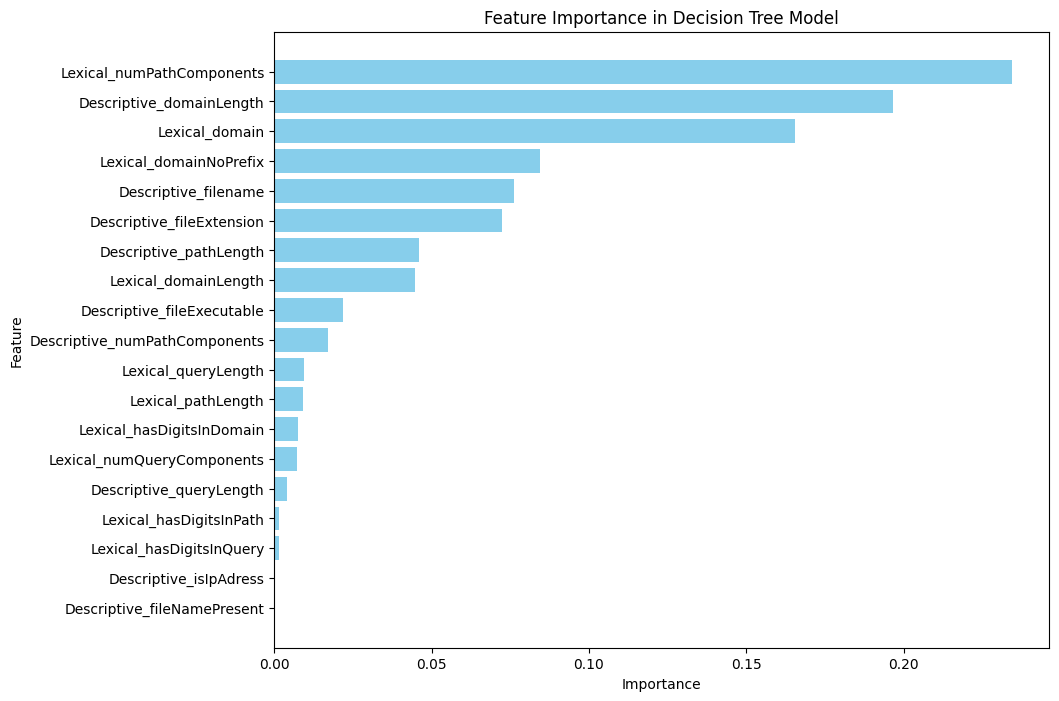

In [21]:
feature_names = [item[0] for item in sorted_features]
importances = [item[1] for item in sorted_features]
plt.figure(figsize=(10, 8))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Decision Tree Model')
plt.gca().invert_yaxis() #most important at the top
plt.show()

See part 2 `2-pup-gpt2.ipynb` for the next steps. 